In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

from collections import Counter

In [15]:
X_cols = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'HOUR_X', 'HOUR_Y',
       'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
       'EMRGVEH_Yes', 'HITANDRUN_Yes', 'MOTORCYCLE_Yes',
       'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'ALCOHOL_INVOLVED_Yes'

In [16]:
crash_data = pd.read_csv('Data/Analysis2/Crash_data_prepared.csv')
X = crash_data.loc[:, X_cols]
y = crash_data.loc[:, y_cols]

---

---

## Statistical Re-sampling
Since the recall was still very low after training our SVM, we will use a statistical re-sampling technique designed for dealing with imbalanced classes, like ours. We'll be using some tools from the [imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html)

---

---

### This seems to be best model!

* `Recall` is our metric of choice. [this article](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) provides a great explanation for why
    * In our instance, we're okay with incorectly guessing that there was alcohol involved with some car crashes, if it means predicting all the instances when there was alcohol involved
    * Generally speaking, when dealing with an imbalanced dataset, oversampling is a good technique to increase recall
* [this](https://beckernick.github.io/oversampling-modeling/) is a great article on the right way to oversmple.

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=742)

In [19]:
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

In [20]:
print(sorted(Counter(y_train_resampled).items()))

[(0, 52335), (1, 52335)]


In [21]:
clf = SVC(kernel='linear')
clf.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95     17418
          1       0.31      0.80      0.44       827

avg / total       0.96      0.91      0.93     18245



In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 15914
True positives: 664
False negatives: 163
False Positives: 1504


In [24]:
confusion_matrix(y_test, y_pred)

array([[15914,  1504],
       [  163,   664]])

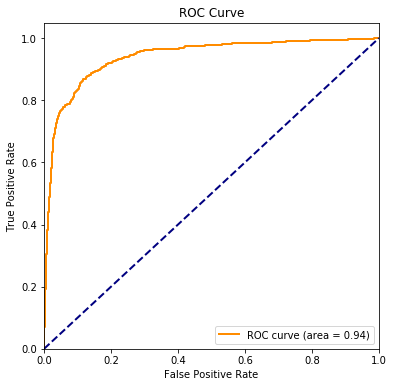

In [48]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize = (6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Thanks to [this page](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) by Scikit-Learn for the great explanation of a normalized confusion matrix

In [39]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.2   0.8 ]]


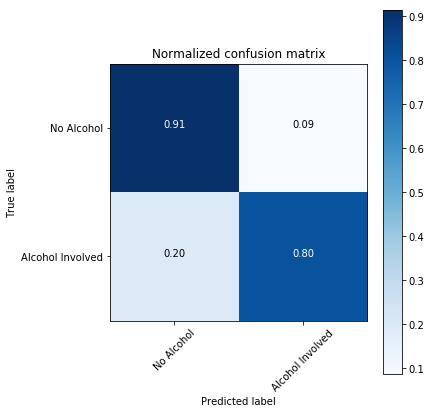

In [47]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=['No Alcohol', 'Alcohol Involved'], normalize=True,
                      title='Normalized confusion matrix')

In [177]:
from sklearn import tree
import graphviz

In [178]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=4)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=4, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

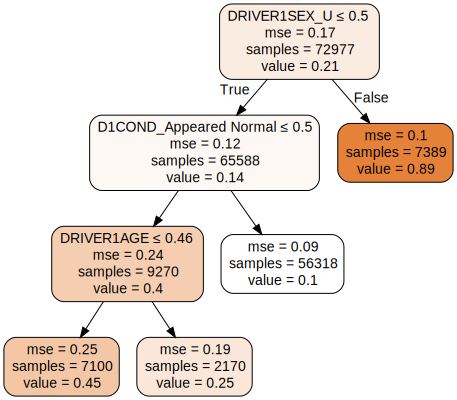

In [179]:
dot_data = tree.export_graphviz(regr, out_file=None, 
                         feature_names=X.columns, 
                         filled=True, rounded=True,  
                         special_characters=True,
                               precision=2)
tree_viz = graphviz.Source(dot_data)
tree_viz